# Jet reconstruction at FCC-ee

In order to make an indirect constraint on the Higgs self-coupling at FCC-ee, we will investigate the ZH process as it is the dominant Higgs production mode at a 240 GeV electron positron collider. While we do not have direct access to the Higgs self-coupling at leading order with this process, we have access to the higgs self-coupling via next to leading order effects (addition of a vertex to the feynman diagrams).

We choose to look at the hadronic final states of the Z decay, as we expect to see more of these events than the leptonic decays. The trade-off is that quarks from hadronically decaying Z bosons will hadronize due to [color confinement](https://en.wikipedia.org/wiki/Color_confinement), so we will need to gather all of their energy in jets.

Because we will have an extremely low level of pileup at FCC-ee, we have the possibility to try different jet reclustering techniques as most of the particles in a given event should be from a single physical process. 

The question we want to answer: 

## Which jet reclustering technique maximizes our signal to background ratio in the signal region?


In order to answer this question, we will start by gaining some understanding of how a given jet reconstruction performs. Let's start by looking at how the particles in a given ZH event are distributed in the detector in the theta-phi plane.

In [631]:
# import required python modules
import uproot
import matplotlib as mpl
import matplotlib.cm
import matplotlib.colors
import matplotlib.lines as mlines
from matplotlib.patches import Ellipse
from matplotlib import pyplot as plt
import pandas
import numpy as np
import awkward #

In [632]:
# Get the values from the TBranch for a given variable and event number
def GetVals(tree, event_number, variable):
    variable_values = tree[variable].array()
    variable_values = variable_values[event_number]
    variable_values = awkward.flatten(variable_values)
    return variable_values


# return two lists, one that specifies edge color and one that specifies shape, based on particle type
def GetColorsShapes(tree, event_number):
    edgecolors = []
    shapes = []
    chargedHad = awkward.flatten(tree["pfcand_isChargedHad"].array()[event_number])
    neutralHad = awkward.flatten(tree["pfcand_isNeutralHad"].array()[event_number])
    el = awkward.flatten(tree["pfcand_isEl"].array()[event_number])
    mu = awkward.flatten(tree["pfcand_isMu"].array()[event_number])
    gamma = awkward.flatten(tree["pfcand_isGamma"].array()[event_number])
    
    for i in range(len(chargedHad)):
        if(chargedHad[i]): # charged hadrons are red circles
            edgecolors.append('r')
            shapes.append('o')
        if(neutralHad[i]): # neutral hadrons are blue squares
            edgecolors.append('b')
            shapes.append('s')
        if(el[i]): # electrons are yellow triangles
            edgecolors.append('y')
            shapes.append('^')
        if(mu[i]): # muons are magenta X's
            edgecolors.append('m')
            shapes.append('X')
        if(gamma[i]): # photons are green stars
            edgecolors.append('g')
            shapes.append('*')
    
    return edgecolors, shapes

# calculate the invariant mass of two jets given their masses, energies, and momenta
def CalcInvarMass(m1, m2, e1, e2, px1, px2, py1, py2, pz1, pz2):
    mass_squared = np.abs(np.square(m1) + np.square(m2) + 2. * (e1 * e2 - px1 * px2 - py1 * py2 - pz1 * pz2))
    invariant_mass = np.round(np.sqrt(mass_squared), 2)
    return invariant_mass

    
# Get which jets are candidates for higgs and z by checking the dijet invariant mass
# Accepts jet mass, jet energy, jet momentum x, y, and z
def GetJetsandMasses(mass, energy, px, py, pz):
    masses = [] # list of masses

    # set the higgs and z mass
    higgs_mass = 125
    zmass = 91.188

    # temporary variables for checking in the loop
    higgs_temp = 0
    ztemp = 0
    
    higgs=[]
    zboson=[]

    # these nested loops calculate all the possible invariant masses and then compare each mass to the set higgs and z to find the closest pairs
    for i in range(len(mass)):    # iterate over all jets

        
        for j in range(i + 1, len(mass)): # iterate over all jet combinations
            if(i == j):
                break    # stops double counting

            # calculate the invariant mass using jet mass, energy, and momentum
            invariant_mass = CalcInvarMass(mass[i], mass[j], energy[i], energy[j], px[i], px[j], py[i], py[j], pz[i], pz[j])
            masses.append(mass)

            # if the difference between the set mass and the calculated mass is less
            # than the difference between the set mass and the previous closest value, this is the new invariant mass
            if(np.abs(zmass - invariant_mass) < np.abs(zmass - ztemp)):
                ztemp = invariant_mass
                zboson = [i,j]    # keep track of the jets

            if(np.abs(higgs_mass - invariant_mass) < np.abs(higgs_mass - higgs_temp)):
                higgs_temp = invariant_mass
                higgs = [i,j]    # keep track of the jets

    return higgs, higgs_temp, zboson, ztemp # return the array of higgs candidate jets, calculated higgs mass, the array of z candidate jets, calculated z mass

# calculate the recoil masses by subtracting a jet pair 4 momentum from (sqrt_s, 0, 0, 0)
def GetRecoilMasses(sqrt_s, energy, px, py, pz):
    masses = [] # list of all masses
    
    for i in range(len(energy)): # iterate over every jet
        if(i+1 > len(energy)):
            break
        
        for j in range(i+1, len(energy)): # iterate over every remaining jet 
            reco_e = sqrt_s - (energy[i] + energy[j]) # recoil energy is center-of-mass energy minus jet pair energy
            reco_px = 0 - (px[i] + px[j])
            reco_py = 0 - (py[i] + py[j])
            reco_pz = 0 - (pz[i] + pz[j])
            
            mass_squared = np.abs(reco_e**2 - reco_px**2 - reco_py**2 - reco_pz**2) # calculate invariant mass
            masses.append(np.round(np.sqrt(mass_squared), 2)) # add invariant mass to list of masses
            
    return masses


# Create a colored ellipse on the graph given an array of jets
# Accepts array of jets, center of ellipse on x, center of ellipse on y, length of ellipse, height of ellipse, color of ellipse, and axis
def AddEllipse(jets, x, y, length, height, color, ax):
    for i in jets:
        ellipse = Ellipse((x[i], y[i]), length, height, color=color, fill=False)
        ax.add_patch(ellipse)
        
# Input jet 1, jet 2, and the total number of jets (starting from 0) to get the index of jet1+jet2 (for example, from the all_invariant_masses branch)
# Many of the lists used are 6 entries long because they come from all the combinations of 4 jets. This function will tell you where a certain combination
# is as long as it's ordered and you know the total number of jets that you have (might have to subtract 1 from total number of jets because it starts from 0)
def GetIndex(n, m, N):
    index = int(n*N - n*(n-1)/2 + (m - n - 1))
    return index


# Plot something 2-dimensional from the root file's contents
def Plot_Particle_Distribution(f, sqrt_s, event_number, weight_by_energy, hist_or_scatt, mass_or_flav):
    # Prepare the plot
    fig, ax = plt.subplots(1, figsize=(6, 4), dpi=400, sharex=True, sharey=True)
    u_f = uproot.open(f) # open file with uproot
    tree = u_f["events"] # define events tree

    # define plot parameters
    xlabel = r"$\phi$ [rad]"
    ylabel = r"$\theta$ [rad]"
    zlabel = r"energy [GeV]"
    fontsize = 15
    
    xmin, xmax = 0, 2*np.pi
    ymin, ymax = 0, np.pi + 1
    
    pfcand_theta_values = GetVals(tree, event_number, "pfcand_theta") # get theta values for "pfcand" (particle flow candidates). These are the particles of the event.
    pfcand_phi_values = GetVals(tree, event_number, "pfcand_phi") # same, but phi values.
    pfcand_phi_values = np.mod(pfcand_phi_values, 2*np.pi)
    
    jet_phi_values = tree["jet_phi"].array()[event_number]
    jet_theta_values = tree["jet_theta"].array()[event_number]
    
    print("pfcand_theta_values:",pfcand_theta_values)
    N_particles = len(pfcand_theta_values) # number of particles in the event.
    print("N_particles:",N_particles)
    
    # weight entry by energy to get rough idea of energy map
    if(weight_by_energy):
        weights = GetVals(tree, event_number, "pfcand_e")
        max_energy = -1
        for i in weights:
            if(i > max_energy):
                max_energy = i
        alpha = weights/max_energy
    else:
        weights = np.array([1 for i in pfcand_theta_values])
        alpha = np.array([0.5 for i in pfcand_theta_values])

    
    # variables used for calculating invariant mass
    jet_e = tree["jet_e"].array()[event_number][:100] # get jet energy
    jet_mass = tree["jet_mass"].array()[event_number][:100] # get jet mass
    jet_px = tree["jet_px"].array()[event_number][:100] # get jet momentum
    jet_py = tree["jet_py"].array()[event_number][:100] # get jet momentum
    jet_pz = tree["jet_pz"].array()[event_number][:100] # get jet momentum

    higgs, higgs_mass, zboson, zmass = GetJetsandMasses(jet_mass, jet_e, jet_px, jet_py, jet_pz) # get the higgs jets and masses, and the z boson jets and masses


    # variables giving the likelihood for a jet or jet pair to have been produced from a b or c quark
    B_scores = tree["recojet_isB"].array()[event_number][:100]
    C_scores = tree["recojet_isC"].array()[event_number][:100]

    print("B scores: ", B_scores)
    print("C scores: ", C_scores)      
            
    # find the best higgs jets using the flavor score method
    bscore_max, bscore_next, jet_max, jet_next = -1, -1, -1, -1
    for i in range(len(B_scores)):
        if(B_scores[i] > bscore_max):
            bscore_next = bscore_max
            bscore_max = B_scores[i]
            jet_next = jet_max
            jet_max = i
        elif(B_scores[i] > bscore_next):
            bscore_next = B_scores[i]
            jet_next = i
            
    higgs_flavored = [min(jet_next, jet_max), max(jet_next, jet_max)]
    
    # find the best z boson jets using the flavor score method
    cscore_max, cscore_next, jet_max, jet_next = -1, -1, -1, -1
    for i in range(len(C_scores)):
        if(C_scores[i] > cscore_max):
            cscore_next = cscore_max
            cscore_max = C_scores[i]
            jet_next = jet_max
            jet_max = i
        elif(C_scores[i] > cscore_next):
            cscore_next = C_scores[i]
            jet_next = i
            
    zboson_flavored = [min(jet_next, jet_max), max(jet_next, jet_max)]

 
    print("higgs jets: ", higgs)
    print("z jets: ", zboson)
    
    print("higgs flavored: ", higgs_flavored)
    print("zboson flavored: ", zboson_flavored)
    
    z_score_by_mass = C_scores[zboson[0]] + C_scores[zboson[1]]
    higgs_score_by_mass = B_scores[higgs[0]] + B_scores[higgs[1]]
    
    z_score_by_flavor = C_scores[zboson_flavored[0]] + C_scores[zboson_flavored[1]]
    higgs_score_by_flavor = B_scores[higgs_flavored[0]] + B_scores[higgs_flavored[1]]
    
    print("higgs score by mass: ", higgs_score_by_mass)
    print("z score by mass: ", z_score_by_mass)
    print("higgs score by flavor: ", higgs_score_by_flavor)
    print("z score by flavor: ", z_score_by_flavor)
    

    # calculate the invariant mass of the flavor score method jets
    higgs_mass_flavor = CalcInvarMass(jet_mass[higgs_flavored[0]], jet_mass[higgs_flavored[1]], jet_e[higgs_flavored[0]], jet_e[higgs_flavored[1]], jet_px[higgs_flavored[0]], jet_px[higgs_flavored[1]], jet_py[higgs_flavored[0]], jet_py[higgs_flavored[1]], jet_pz[higgs_flavored[0]], jet_pz[higgs_flavored[1]])
    z_mass_flavor = CalcInvarMass(jet_mass[zboson_flavored[0]], jet_mass[zboson_flavored[1]], jet_e[zboson_flavored[0]], jet_e[zboson_flavored[1]], jet_px[zboson_flavored[0]], jet_px[zboson_flavored[1]], jet_py[zboson_flavored[0]], jet_py[zboson_flavored[1]], jet_pz[zboson_flavored[0]], jet_pz[zboson_flavored[1]])

    # calculate the recoil masses
    calc_recoil = GetRecoilMasses(sqrt_s, jet_e, jet_px, jet_py, jet_pz)
    print("calc recoil: ", calc_recoil)

    if(hist_or_scatt==0):
    # Create the 2D histogram plot
        plt.hist2d(pfcand_phi_values, pfcand_theta_values, weights=weights, bins=40, norm=mpl.colors.LogNorm(), cmap='plasma', range=np.array([(xmin, xmax), (ymin, ymax)])) # make 2D histogram, weight entries by something if desired
        plt.plot(jet_phi_values, jet_theta_values, 'D', markerfacecolor='c', markeredgecolor='k') # plot the centers of each jet
        plt.colorbar(label = zlabel) # make color bar
        if(mass_or_flav==0):
            plt.title('4 Jet mass reconstruction of ZccHbb (event ' + str(event_number) + ')')
        if(mass_or_flav==1):
            plt.title('4 Jet flavor reconstruction of ZccHbb (event ' + str(event_number) + ')')
        plt.xlabel(xlabel, fontsize=fontsize)
        plt.ylabel(ylabel, fontsize=fontsize)
        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)
        plt.tick_params(axis='both', labelsize=fontsize) # make the tick label sizes larger as well, so that others will be able to see when you share the plot

        jet_label = mlines.Line2D([], [], markeredgecolor='k', markerfacecolor='c', marker='D', linewidth=0, label='Calculated center of jet')
        handles=[jet_label]
        
        plot_higgs = False # false when looking only for z boson candidates
        
        # add a circle around each jet to categorize as z or higgs candidate
        ellipse_length = 1.075
        ellipse_height = 0.75

        # using invariant mass method
        if(mass_or_flav==0):
            AddEllipse(zboson, jet_phi_values, jet_theta_values, ellipse_length, ellipse_height, 'r', ax)
            z_label_mass = mpl.patches.Patch(color='red', label='Z candidate, mass: ' + str(round(zmass, 2)) + ' GeV, jet pair C score: ' + str(round(z_score_by_mass, 3)))
            handles.append(z_label_mass) # add z label to list of handles for the histogram
            
            if(plot_higgs): # usually false
                AddEllipse(higgs, jet_phi_values, jet_theta_values, ellipse_length, ellipse_height, 'b', ax)
                higgs_label_mass = mpl.patches.Patch(color='blue', label='Higgs candidate, calculated invariant mass: ' + str(round(higgs_mass, 2)) + ', isB score: ' + str(round(higgs_score_by_mass, 3)))
                handles.append(higgs_label_mass) # add higgs label to list of handles for the histogram
        # using flavor score method   
        if(mass_or_flav==1):
            AddEllipse(zboson_flavored, jet_phi_values, jet_theta_values, ellipse_length, ellipse_height, 'r', ax)
            z_label_flavor = mpl.patches.Patch(color='red', label='Z candidate, mass: ' + str(round(z_mass_flavor, 2)) + ' GeV, jet pair C score: ' + str(round(z_score_by_flavor, 3)))
            handles.append(z_label_flavor) # add z label to list of handles for the histogram
            
            if(plot_higgs): # usually false
                AddEllipse(higgs_flavored, jet_phi_values, jet_theta_values, ellipse_length, ellipse_height, 'b', ax)
                higgs_label_flavor = mpl.patches.Patch(color='blue', label='Higgs candidate, calculated invariant mass: ' + str(round(higgs_mass_flavor, 2)) + ', isB score: ' + str(round(higgs_score_by_flavor, 3)))
                handles.append(higgs_label_flavor) # add higgs label to list of handles for the histogram
                

        plt.axhline(y=np.pi) # horizontal line for the legend

        plt.legend(handles=handles, fontsize=7)
        if(mass_or_flav==0):
            plt.text(3.0, 3.4, "Jets chosen by jet pair invariant mass", fontsize=7, weight='bold')
        elif(mass_or_flav==1):
            plt.text(3.0, 3.4, "Jets chosen by jet pair C score", fontsize=7, weight='bold')

        fig.tight_layout()
        fig.show() # show the plot in the notebook cell
        if(mass_or_flav==0):
            fig.savefig("pics/4 Jet mass reconstruction of Z(cc)H(bb) (" + str(event_number) + ").png") # save the image
        elif(mass_or_flav==1):
            fig.savefig("pics/4 Jet flavor reconstruction of Z(cc)H(bb) (" + str(event_number) + ").png") # save the image
            
#     Create the scatter plot
    if(hist_or_scatt==1):
        # create all of the legend markers
        chargedHad = mlines.Line2D([], [], markerfacecolor='w', markeredgecolor='red', marker='o', linewidth=0, label='charged hadron')
        neutralHad = mlines.Line2D([], [], markerfacecolor='w', markeredgecolor='blue', marker='s', linewidth=0, label='neutral hadron')
        electron = mlines.Line2D([], [], markerfacecolor='w', markeredgecolor='yellow', marker='^', linewidth=0, label='electron')
        muon = mlines.Line2D([], [], markerfacecolor='w', markeredgecolor='magenta', marker='X', linewidth=0, label='muon')
        gamma = mlines.Line2D([], [], markerfacecolor='w', markeredgecolor='green', marker='*', linewidth=0, label='gamma')
        jet = mlines.Line2D([], [], color='k', marker='x', linewidth=0, label='jet center')

        colors, shapes = GetColorsShapes(tree, event_number)
        for i in range(len(pfcand_phi_values)):
            f = plt.scatter(pfcand_phi_values[i], pfcand_theta_values[i],c='w', edgecolors=colors[i], alpha=alpha[i], marker=shapes[i])

        plt.plot(jet_phi_values, jet_theta_values, 'x', c='k') # plot the centers of each jet
        plt.title('Z(cc)H(bb) decay particle type and position (event ' + str(event_number) + ')')
        plt.xlabel(xlabel, fontsize=fontsize)
        plt.ylabel(ylabel, fontsize=fontsize)
        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)
        plt.tick_params(axis='both', labelsize=fontsize) # make the tick label sizes larger as well, so that others will be able to see when you share the plot
        plt.legend(handles = [chargedHad, jet, neutralHad, electron, muon, gamma], ncol=5, fontsize=7)
    #    plt.text(3.5, 3.4, "Transparency scaled by particle energy", fontsize=7, weight='bold')

        fig.tight_layout()
        fig.show()
#        fig.savefig("pics/Z(cc)H(bb) decay particle type and position (" + str(event_number) + ").png") # save the image

# function for calculating all of the necessary information for plotting a histogram of many events (for looking at Z mass or recoil mass over nevents)
# can include background, right now is hard-coded for the order: Z(cc)H(bb), ZZ, Zqq, WW
def Calc_Z_and_Recoil(files, z_or_recoil, sqrt_s, nevents, mass_or_flav, cuts):
    background_z = []
    background_recoil = []
    
    invar_z_masses_and_labels = []
    invar_recoil_masses_and_labels = []
    flav_z_masses_and_labels = []
    flav_recoil_masses_and_labels = []
    
    processes = [["ccH_Hcc", 'b'], ["ccH_Hbb", 'r'], ["ZZ", 'g'], ["Zqq", 'c'], ["WW", 'm']]

    # check which process is happening so the label can be changed
    for f in files:        
        file_label = "*"
        stacked=True
        fill=True
        for i in processes:
            if(f.find(i[0]) != -1):
                label_file = i[0]
                color = i[1]
                if(label_file == "ccH_Hbb"):
                    fill=False
                    stacked=False
        
        u_f = uproot.open(f)
        tree = u_f["events"]

        jet_e = tree["jet_e"].array()[:nevents]
        jet_mass = tree["jet_mass"].array()[:nevents]
        jet_px = tree["jet_px"].array()[:nevents]
        jet_py = tree["jet_py"].array()[:nevents]
        jet_pz = tree["jet_pz"].array()[:nevents]
        C_scores = tree["recojet_isC"].array()[:nevents]


        all_z_invar_masses = []
        all_z_flav_masses = []
        all_recoil_invar_masses = []
        all_recoil_flav_masses = []

        higgs=[]

        # calculate all of the invariant mass information and flavor score information
        for i in range(len(jet_e)):
            higgs, higgs_mass, zboson, zmass = GetJetsandMasses(jet_mass[i], jet_e[i], jet_px[i], jet_py[i], jet_pz[i]) # get invariant mass jets

            # get flavor score jets
            cscore_max, cscore_next, jet_max, jet_next = -1, -1, -1, -1
            for j in range(len(C_scores[i])):
                if(C_scores[i][j] > cscore_max):
                    cscore_next = cscore_max
                    cscore_max = C_scores[i][j]
                    jet_next = jet_max
                    jet_max = j
                elif(C_scores[i][j] > cscore_next):
                    cscore_next = C_scores[i][j]
                    jet_next = j

            zboson_flavored = [min(jet_next, jet_max), max(jet_next, jet_max)]

            if(zboson_flavored[0] != -1): # to make sure we aren't looking at the events where no jets were found
                recoil_mass = GetRecoilMasses(sqrt_s, jet_e[i], jet_px[i], jet_py[i], jet_pz[i])

                # if applying cuts, only add the jet pair mass to the list of masses if C_score > 1.6 and mass between threshold of 85-95 GeV
                if(cuts):
                    if(1.6 < C_scores[i][zboson_flavored[0]] + C_scores[i][zboson_flavored[1]] and 85 < zmass < 95):
                        if(z_or_recoil%2==0):
                            all_z_invar_masses.append(zmass)

                            zmass_flav = CalcInvarMass(jet_mass[i][int(zboson_flavored[0])], jet_mass[i][int(zboson_flavored[1])], jet_e[i][int(zboson_flavored[0])], jet_e[i][int(zboson_flavored[1])], jet_px[i][int(zboson_flavored[0])], jet_px[i][int(zboson_flavored[1])], jet_py[i][int(zboson_flavored[0])], jet_py[i][int(zboson_flavored[1])], jet_pz[i][int(zboson_flavored[0])], jet_pz[i][int(zboson_flavored[1])])
                            all_z_flav_masses.append(zmass_flav)
                        if(z_or_recoil>0):
                            all_recoil_invar_masses.append(recoil_mass[GetIndex(zboson[0], zboson[1], len(jet_e[i])-1)])
                            all_recoil_flav_masses.append(recoil_mass[GetIndex(int(zboson_flavored[0]), int(zboson_flavored[1]), len(jet_e[i])-1)])
#                            print("recoil mass: {}, flav: {}".format(recoil_mass[GetIndex(zboson[0], zboson[1], len(jet_e[i])-1)], recoil_mass[GetIndex(int(zboson_flavored[0]), int(zboson_flavored[1]), len(jet_e[i])-1)]))
                            
                else:
                    if(z_or_recoil%2==0):
                        all_z_invar_masses.append(zmass)
                        
                        zmass_flav = CalcInvarMass(jet_mass[i][int(zboson_flavored[0])], jet_mass[i][int(zboson_flavored[1])], jet_e[i][int(zboson_flavored[0])], jet_e[i][int(zboson_flavored[1])], jet_px[i][int(zboson_flavored[0])], jet_px[i][int(zboson_flavored[1])], jet_py[i][int(zboson_flavored[0])], jet_py[i][int(zboson_flavored[1])], jet_pz[i][int(zboson_flavored[0])], jet_pz[i][int(zboson_flavored[1])])
                        all_z_flav_masses.append(zmass_flav)
                    if(z_or_recoil>0):
                        all_recoil_invar_masses.append(recoil_mass[GetIndex(zboson[0], zboson[1], len(jet_e[i])-1)])
                        all_recoil_flav_masses.append(recoil_mass[GetIndex(int(zboson_flavored[0]), int(zboson_flavored[1]), len(jet_e[i])-1)])

        # add all of the invariant z masses, recoil masses with labels; flavor z masses, recoil masses with labels
        invar_z_masses_and_labels.append([all_z_invar_masses, label_file, color, stacked, fill])
        invar_recoil_masses_and_labels.append([all_recoil_invar_masses, label_file, color, stacked, fill])
        flav_z_masses_and_labels.append([all_z_flav_masses, label_file, color, stacked, fill])
        flav_recoil_masses_and_labels.append([all_recoil_flav_masses, label_file, color, stacked, fill])

        print(color) # prints the color of each process on the histogram, also nice for seeing code progress (prints after done with each process)
    
    return invar_z_masses_and_labels, invar_recoil_masses_and_labels, flav_z_masses_and_labels, flav_recoil_masses_and_labels


# plot information calculate in Calc_Z_and_Recoil
def Plot_Z_and_Recoil(z_masses_and_labels, recoil_masses_and_labels, z_or_recoil, sqrt_s, nevents, mass_or_flav, cuts):
    # Make the plot
    fig, ax = plt.subplots(1, figsize=(6, 4), dpi=400)
    
    if(z_or_recoil==0):
        xmin, xmax, nbins, xlabel = 0, 200, 100, "Z Candidate Mass [GeV]" # set binning and x label
    if(z_or_recoil==1):
        xmin, xmax, nbins, xlabel = 0, 200, 100, "Recoil Mass [GeV]" # set binning and x label

    ylabel = "Entries"
    normalize = 1
    
    bins = np.linspace(xmin, xmax, nbins + 1)
    
    entries = []
    labels = []
    colors = []
    stackeds = []
    fills = []
    
    # if looking at zmasses, use the z_masses_and_labels list
    if(z_or_recoil%2==0):
        for i in z_masses_and_labels:
            entries.append(i[0])
            labels.append(i[1])
            colors.append(i[2])
            stackeds.append(i[3])
            fills.append(i[4])

    # if looking at recoil masses, use the recoil_masses_and_labels list 
    if(z_or_recoil>0):
        for i in recoil_masses_and_labels:
            entries.append(i[0])
            labels.append(i[1])
            colors.append(i[2])
            stackeds.append(i[3])
            fills.append(i[4])
            
    # calculated scaling factors of signal to background. in order: ZccHbb, ZZ, Zqq, WW
    scales = [97848/nevents, 9784728/nevents, 379108080/nevents, 118357200/nevents]

    weights = []
    # add the scaling factors to a list called "weights"
    for i in range(len(entries)):
        temp = []
        weights.append(temp)
        for j in range(len(entries[i])):
            weights[i].append(scales[i])
            
    # the signal histogram is just the first element of all of the lists of variables that we've been appending things to, so take out the first element and create a new list
    signal = [entries.pop(0), labels.pop(0), colors.pop(0), stackeds.pop(0), fills.pop(0), weights.pop(0)]
    print("weight: ", signal[5][0])
    for i in range(len(signal[5])):
        signal[5][i] = signal[5][i] * 50

    print("weight (again): ", signal[5][0])

    plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))


    
    #backgrounds
    plt.hist(entries, bins, alpha=0.5, fill=fills,  label=labels, color=colors, stacked=stackeds, weights=weights, log=False)
    #signal
    plt.hist(signal[0], bins, alpha=1, fill=False,  label='Z(cc)H(bb) x 50', edgecolor='r', stacked=signal[3], histtype='step', hatch='/', weights=signal[5], log=False, linewidth=1.5)

    ylim = ax.get_ylim()
    plt.ylim(0,ylim[1]*1.25)

    print("scales: ", scales)
    
    signal_yield = 0
    background_yield = 0
    
    for i in signal[0]: # iterate over every entry in the signal
        if(115<i<135):  # if value within 115-135, add it
            signal_yield = signal_yield + scales[0]
            
    scales.pop(0) # remove the first value to not interfere
    
    for i in range(len(entries)): # iterate over every type of background
        for j in entries[i]:      # iterate over every entry in specific background
            if(115<j<135): # if value within 115-135, add it
                background_yield = background_yield + scales[i] # add specific scaling value
                
    
    print("S: ", signal_yield)
    print("B: ", background_yield)
    print("S/sqrt(B) = ", signal_yield / np.sqrt(background_yield))

    fontsize = 15
    # Set axis labels with custom font size - 
    plt.xlabel(xlabel, fontsize=fontsize)
    plt.ylabel(ylabel, fontsize=fontsize)
    plt.tick_params(axis='both', labelsize=fontsize) # make the tick label sizes larger as well, so that others will be able to see when you share the plot

    if(z_or_recoil==1):
        if(mass_or_flav==0):
            plt.text(0, ax.get_ylim()[1]-ax.get_ylim()[1]/8, "Jets chosen by jet pair invariant mass" "\n" "w/ cuts at 85 to 95 GeV on Z candidate mass" "\n" "and at 1.6 on flavor score", fontsize=7, weight='bold')
        elif(mass_or_flav==1):
            plt.text(0, ax.get_ylim()[1]-ax.get_ylim()[1]/8, "Jets chosen by jet pair flavor score" "\n" "w/ cuts at 85 to 95 GeV on Z candidate mass" "\n" "and at 1.6 on flavor score", fontsize=7, weight='bold')


    if(z_or_recoil==0):
        plt.title("Z candidate masses w/ background over " + str(nevents) + " events")

    if(z_or_recoil==1):
        plt.title("Recoil masses w/ background over " + str(nevents) + " events")

    if(z_or_recoil==2):
        plt.title("Z candidate and recoil masses w/ background over " + str(nevents) + " events")

    plt.legend()
    plt.axvline(115, linestyle='--')
    plt.axvline(135, linestyle='--')

#    for i in range(len(bins)):
        
    
    print(bins)
    
    fig.tight_layout()
    fig.show()
    
    if(z_or_recoil==0):
        fig.savefig("pics/Z candidate + background over " + str(nevents) + " events.png") # save the image
    if(z_or_recoil==1):
        if(mass_or_flav==0):
            fig.savefig("pics/Invariant mass - recoil mass + background over " + str(nevents) + " events.png") # save the image
        if(mass_or_flav==1):
            fig.savefig("pics/Flavor score - recoil mass + background over " + str(nevents) + " events.png") # save the image

    if(z_or_recoil==2):
        fig.savefig("pics/Z candidate and recoil masses + background over " + str(nevents) + " events.png") # save the image


In [633]:
#file = "~/BNL-Analyses/ZccH_4JetReco/stage1/wzp6_ee_ccH_Hbb_ecm240.root" # 100 events of Z(cc)H(bb) where an exclusive jet reclustering is performed, in n-jets mode, with n-jets = 4.
file = "~/BNL-Analyses/ZccH_4JetReco/stage1/p8_ee_ZZ_ecm240.root" # 100 events of Z(cc)H(bb) where an exclusive jet reclustering is performed, in n-jets mode, with n-jets = 4.
u_f = uproot.open(file) # open file with uproot to look at branches
tree = u_f["events"]
variables = sorted(tree.keys())
print("Variables:")
print("")
for v in variables:
    print(v)

Variables:

all_invariant_masses
event_njet
jet_e
jet_mass
jet_nchad
jet_nconst
jet_nel
jet_ngamma
jet_nmu
jet_nnhad
jet_p
jet_phi
jet_px
jet_py
jet_pz
jet_theta
pfcand_btagJetDistSig
pfcand_btagJetDistVal
pfcand_btagSip2dSig
pfcand_btagSip2dVal
pfcand_btagSip3dSig
pfcand_btagSip3dVal
pfcand_cctgtheta
pfcand_cdz
pfcand_charge
pfcand_detadeta
pfcand_dlambdadz
pfcand_dndx
pfcand_dphidphi
pfcand_dphidxy
pfcand_dptdpt
pfcand_dxy
pfcand_dxyc
pfcand_dxyctgtheta
pfcand_dxydxy
pfcand_dxydz
pfcand_dz
pfcand_dzdz
pfcand_e
pfcand_erel_log
pfcand_isChargedHad
pfcand_isEl
pfcand_isGamma
pfcand_isMu
pfcand_isNeutralHad
pfcand_mtof
pfcand_p
pfcand_phi
pfcand_phic
pfcand_phictgtheta
pfcand_phidz
pfcand_phirel
pfcand_theta
pfcand_thetarel
pfcand_type
recoil_masses
recojet_isB
recojet_isC
recojet_isG
recojet_isQ
recojet_isS
recojetpair_isB
recojetpair_isC


pfcand_theta_values: [0.314, 0.421, 0.784, 1.02, 0.194, 0.359, ... 1.54, 1.45, 1.78, 1.65, 1.86, 1.75]
N_particles: 90
invariant masses:  [136, 88.4, 58.4, 54.2, 55.2, 36.6]
B scores:  [0.0267, 0.996, 0.245, 0.356]
C scores:  [0.832, 6.77e-06, 0.716, 0.544]
B pair scores:  [1.02, 0.271, 0.382, 1.24, 1.35, 0.6]
C pair scores:  [0.832, 1.55, 1.38, 0.716, 0.544, 1.26]
higgs jets:  [0, 1]
z jets:  [0, 2]
higgs flavored:  [1, 3]
zboson flavored:  [0, 2]
higgs score by mass:  1.0230725202709436
z score by mass:  1.5477630496025085
higgs score by flavor:  1.352126955986023
z score by flavor:  1.5477630496025085


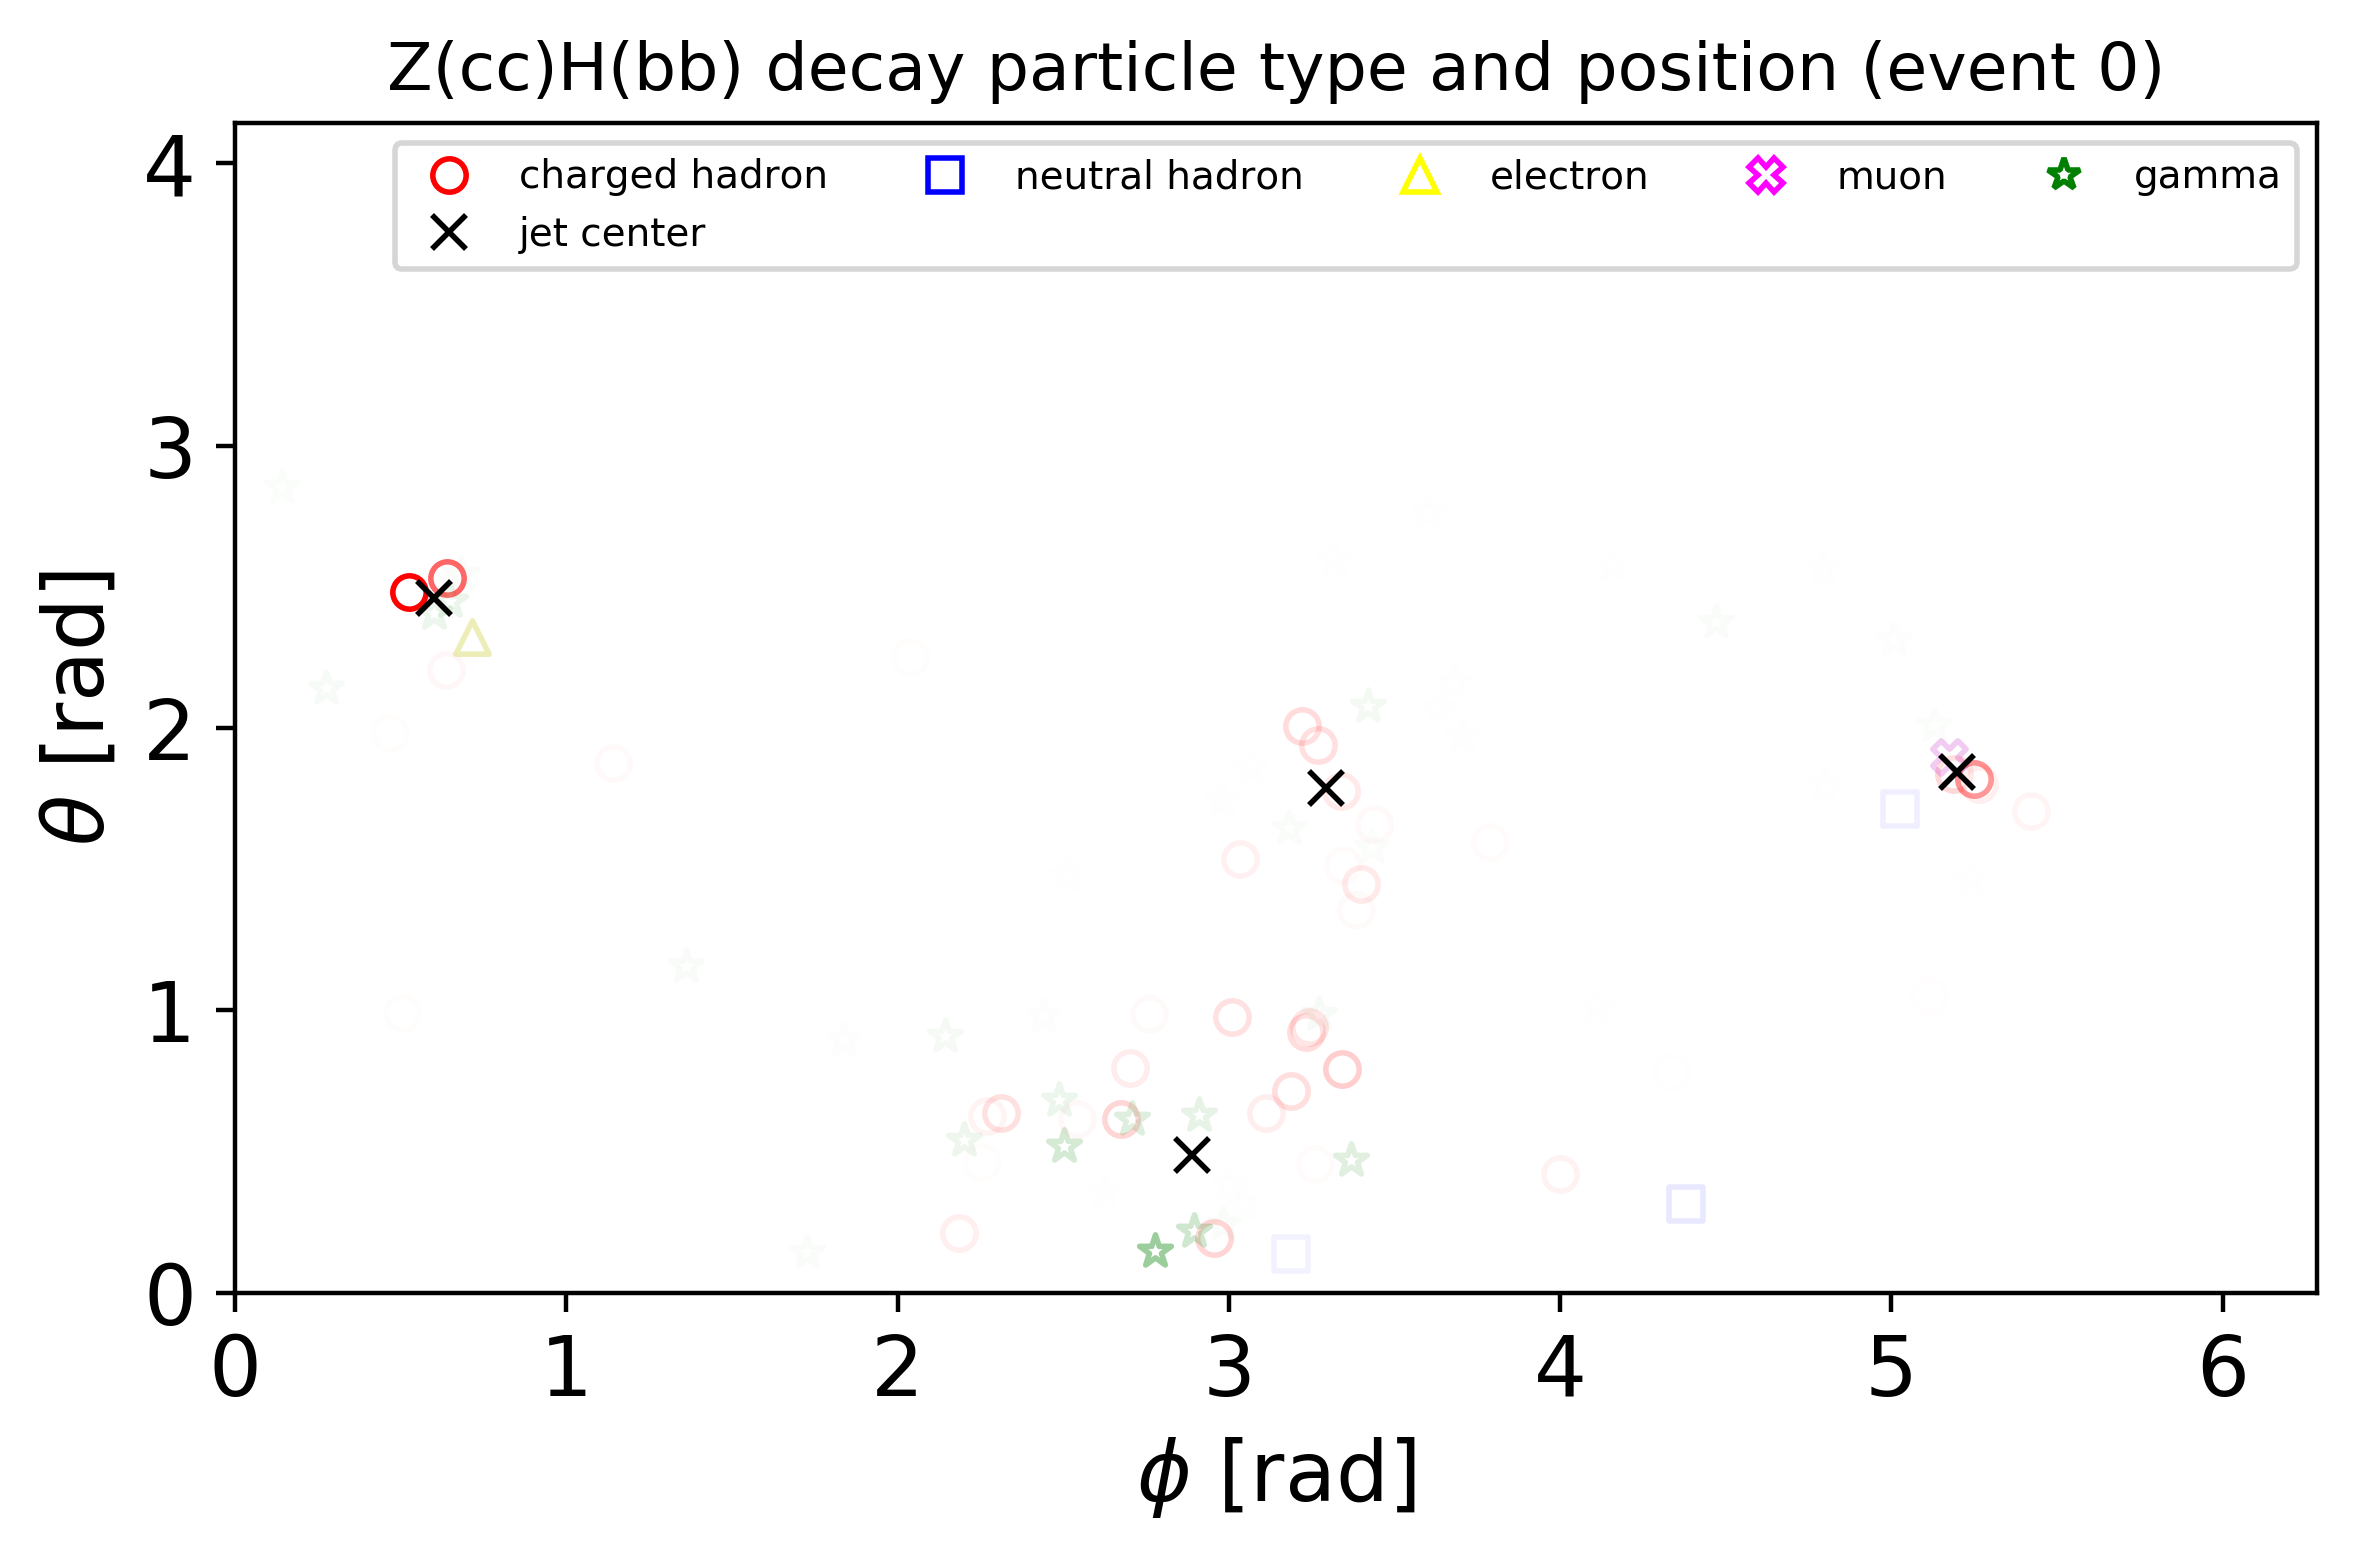

In [634]:
event_number = 0
sqrt_s = 240
weight_by_energy = 1
hist_or_scatt = 0
mass_or_flav = 1
Plot_Particle_Distribution(file, sqrt_s, event_number, weight_by_energy, hist_or_scatt, mass_or_flav)

# To do next:

* Change binning: theta from 0 to pi, phi from -pi to +pi.
* Weight histogram entries by particle energy. This will give us an idea of how the energy of the particles in concentrated.
* Look at some more events, get some idea of how particles are spread in these hadronic ZH events.
* Add points with locations of the four jets produced by the algorithm. Should be contained in the branches "jet_phi" and "jet_theta" - should have four entries per event. 
* Seprate scatter plot of particle types for a given event to get an idea of how different particles are produced and spread during hadronization. Just make a scatter plot, and use the `pfcand_is*` flag to determine the marker type.
* Compute invariant mass (do the calculation) for each pairing of jets, compare to all_invariant_masses branch. Figure out which pair is most likely to have come from Z, and which from Higgs, label them on the plot. 

## After completing the above

* Then find R parameter for a given jet (need to check FCCAnalyses code) to make a circle around theta, phi for a jet to see how much energy it contains. Should also plot their flavour scores (recojet_isB, recojet_isC) --> should also have four entries per event corresponding to the jets.
* Add truth information to see how far off the reconstructed jets are from the generated quarks.
* Check if scores add up to one: 
recojet_isB
recojet_isC
recojet_isG
recojet_isQ
recojet_isS

In [ ]:
files = ["~/BNL-Analyses/ZccH_4JetReco/stage1/wzp6_ee_ccH_Hbb_ecm240.root", "~/BNL-Analyses/ZccH_4JetReco/stage1/p8_ee_ZZ_ecm240.root", "~/BNL-Analyses/ZccH_4JetReco/stage1/p8_ee_Zqq_ecm240.root", "~/BNL-Analyses/ZccH_4JetReco/stage1/p8_ee_WW_ecm240.root"]
z_or_recoil = 1
sqrt_s = 240
nevents = 100000
mass_or_flav = 0
cuts = True

invar_z_masses_and_labels, invar_recoil_masses_and_labels, flav_z_masses_and_labels, flav_recoil_masses_and_labels = Calc_Z_and_Recoil(files, z_or_recoil, sqrt_s, nevents, mass_or_flav, cuts)

In [ ]:
mass_or_flav=1

if(mass_or_flav==0):
    Plot_Z_and_Recoil(invar_z_masses_and_labels, invar_recoil_masses_and_labels, z_or_recoil, sqrt_s, nevents, mass_or_flav, cuts)
if(mass_or_flav==1):
    Plot_Z_and_Recoil(flav_z_masses_and_labels, flav_recoil_masses_and_labels, z_or_recoil, sqrt_s, nevents, mass_or_flav, cuts)

In [ ]:
# function for plotting C scores over many events, code is mostly copied straight from the previous function

def Plot_C_Score(files, z_or_recoil, sqrt_s, nevents, mass_or_flav, cuts):
    # Make the plot
    fig, ax = plt.subplots(1, figsize=(6, 5), dpi=300)
    
    xmin, xmax, nbins, xlabel = 0, 2, 20, "Jet Pair Charm Flavor Score" # set binning and x label

    ylabel = "Entries"

    c_scores_and_labels = []
    
    processes = [["ccH_Hcc", 'b'], ["ccH_Hbb", 'r'], ["ZZ", 'g'], ["Zqq", 'c'], ["WW", 'm']]
    for f in files:
        
        stacked=True
        fill=True
        for i in processes:
            if(f.find(i[0]) != -1):
                label_file = i[0]
                color = i[1]
                if(label_file == "ccH_Hbb"):
                    fill=False
                    stacked=False
        
        u_f = uproot.open(f)
        tree = u_f["events"]

        jet_e = tree["jet_e"].array()[:nevents]


        all_c_scores = []

        if(mass_or_flav==1):
    #        all_invariant_masses = tree["all_invariant_masses"].array()[:nevents] # get invariant mass
            C_scores = tree["recojet_isC"].array()[:nevents]

            for i in range(len(jet_e)):

                cscore_max, cscore_next, jet_max, jet_next = -1, -1, -1, -1
                for j in range(len(C_scores[i])):
                    if(C_scores[i][j] > cscore_max):
                        cscore_next = cscore_max
                        cscore_max = C_scores[i][j]
                        jet_next = jet_max
                        jet_max = j
                    elif(C_scores[i][j] > cscore_next):
                        cscore_next = C_scores[i][j]
                        jet_next = j

                if(cscore_next != -1 and cscore_max != -1):
#                    print("cscore_max + cscore_next: ", cscore_max + cscore_next)
                    all_c_scores.append(cscore_max + cscore_next)


#            plt.text(0, 1500000, "Jets chosen by jet pair flavor score", fontsize=7, weight='bold')

            c_scores_and_labels.append([all_c_scores, label_file, color, stacked, fill])

        print(color)
    bins = np.linspace(xmin, xmax, nbins)
    
    entries = []
    labels = []
    colors = []
    stackeds = []
    fills = []
    
    for i in c_scores_and_labels:
        entries.append(i[0])
        labels.append(i[1])
        colors.append(i[2])
        stackeds.append(i[3])
        fills.append(i[4])
            
    
    scales = [97848/nevents, 9784728/nevents, 379108080/nevents, 118357200/nevents]

    weights = []
    for i in range(len(entries)):
        temp = []
        weights.append(temp)
        for j in range(len(entries[i])):
            weights[i].append(scales[i])
            
    signal = [entries.pop(0), labels.pop(0), colors.pop(0), stackeds.pop(0), fills.pop(0), weights.pop(0)]
    for i in range(len(signal[5])):
        signal[5][i] = signal[5][i] * 100

    plt.hist(entries, bins, alpha=0.5, fill=fills,  label=labels, color=colors, stacked=stackeds, weights=weights, log=False)
    plt.hist(signal[0], bins, alpha=1, fill=False,  label='Z(cc)H(bb) x100', edgecolor='r', stacked=signal[3], histtype='step', hatch='/', weights=signal[5], log=False, linewidth=1.5)


    fontsize = 15
    # Set axis labels with custom font size - 
    plt.xlabel(xlabel, fontsize=fontsize)
    plt.ylabel(ylabel, fontsize=fontsize)
    plt.tick_params(axis='both', labelsize=fontsize) # make the tick label sizes larger as well, so that others will be able to see when you share the plot
    
    plt.axvline(1.6, linestyle='--')
#    plt.text(0, ax.get_ylim()[1]-ax.get_ylim()[1]/10, "Jets chosen by jet pair invariant mass" "\n" "w/ cuts at 85 to 95 GeV on Z candidate mass", fontsize=7, weight='bold')

    plt.title("Z candidate charm scores w/ background")

    plt.legend()
    
#    fig.tight_layout()
    fig.show()
    
    fig.savefig("pics/Charm scores " + str(nevents) + " events.png") # save the image

In [ ]:
Plot_C_Score(files, 1, sqrt_s, nevents, 1, False)